## https://github.com/0403minukim/DL

# 1. Settings

### 1) Important required libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyperparameter

In [3]:
batch_size=16   #64   #1
learning_rate = 0.0001
epoch = 20

n_node = 1024   # customized last layer 의 노드 수 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio

imgsize = 256

# 2. Data Loader

### 트레이닝 데이터

In [4]:
#img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4k/Train"
img_dir = "animal/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([
            # ①(512)③②RCrop   <-- Best   !!
            transforms.CenterCrop(imgsize*2),   # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),   # ③ RandomCrop
            transforms.RandomHorizontalFlip(),   # ② RandomHorizontalFlip
            
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size,
                             shuffle = True, num_workers = 2)

46


### 고정된 데이터 셋 

In [5]:
# 2. Dev data
#img_dir = "../../../images/painting_dataset/real_artwork_divided_shffl_4k/Valid"
img_dir = "animal/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
dev_batch =data.DataLoader(dev_data,batch_size=batch_size,
                           shuffle=True,num_workers=2)

In [6]:
# 3. Test data

img_dir = "animal/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
test_batch =data.DataLoader(test_data,batch_size=batch_size,
                           shuffle=True,num_workers=2)

In [7]:
nclass =len(train_data.classes)
print("# of classes: %d"%nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
     %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

#for imgs, labels in train_batch:
#    for j in range(len(imgs)):
#        img=transforms.ToPILImage()(imgs[j])
#        plt.title("label: %d"% labels[j])
#        plt.imshow(img)
#        plt.show()

# of classes: 2
['cats', 'dogs']
{'cats': 0, 'dogs': 1}
46
Training: 46, Dev: 17, Test: 41


(None,)

In [8]:
# '.ipynb_checkpoints' 가 클래스로 나오는 경우, 새로운 폴더(train, val, test) 를 만들어 이동 시킬 것
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['cats', 'dogs']
['cats', 'dogs']
['cats', 'dogs']


# 3. Model

### 1) Pretrained VGG Model

In [9]:
vgg =models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)
    
print(list(vgg.children())[0])
print(list(vgg.children())[-1])

#cnt=0
#for i in model.children():
#    print("yhk[%d]"%cnt),
#    pirnt(i)
#    cnt = cnt+1

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [10]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 2) Customized Fully Model

In [11]:
base_dim=64
fsize=int(imgsize/32)

class MyYGG(nn.Module):
    def __init__(self):
        super(MyYGG, self).__init__()
        # [0]: features(conv), [1]: classifier(fc)
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        
        self.layer1=nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),   # 0.3 만큼 dorp 하자.
            
            nn.Linear(n_node,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node,n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node,nclass)
        )
        # weight initializtion
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m,nn.Conv2d):
                init.kaiming_normal(m.weight.data)   # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m,nn.Linear):
                init.kaiming_normal(m.weight.data)   
                m.bias.data.fill_(0)
    def forward(self,x):
        # layer0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x,x,x)
        #print(x.size())
        out =self.layer0(x)
        out = out.view(out.size(0),-1)
        out = self.layer1(out)
        return out

### 3) Module on GPU

In [12]:
model=  MyYGG().cuda()

for params in model.layer0.parameters():
    params.required_grad= False
    
for params in model.layer1.parameters():
    params.required_grad=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [13]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# 4. Optimizer & Loss

In [15]:
loss_func= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

# 5. Train

In [16]:
import utils

total_time = 0
disp_step=10

to_train=True
if(to_train==False):
    #netname='./netsmedia_vgg19_fixed.pkl'
    netname='./nets/catdogg_vgg19_10.pkl'
    model =torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f"%(n_node,dropratio))
    model.eval()   #evaluation(test) mode 로 바꾸기 -> dropout,batch normalization 에 영향을 줌.
    train_corr=utils.ComputeCorr(train_batch,model)
    dev_corr=utils.ComputeCorr(dev_batch,model)
    test_corr=utils.ComputeCorr(test_batch,model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f"
         %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname='./nets/catdog_vgg19'
    
    # graph 그리기
    x_epoch =[]
    y_train_err =[]
    y_dev_err = []
    y_test_err=[]
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#   # 학습을 재시작한다면
#    netname = '../nets/media_pre_vgg19.pkl'
#    model = torch.load(netname)
#    # 파라미터 학습 여부 결정
#    for params in model.layer0.parameters():
#        params.required_grad= False    
#    for params in model.layer1.parameters():
#        params.required_grad=True
#    for i in range(34, epoch):
    #재시작하지 않는다면
    for i  in range(epoch):
        start_time=time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img=Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output=model(img)
            loss=loss_func(output,label)
            loss.backward()
            optimizer.step()
        end_time =time.time()
        duration=end_time-start_time
        total_time+=duration
        if(i%disp_step==0)or(i==epoch-1):
            torch.save(model,netname+'_%d.pkl'%i,)
            print("\n[%d/%d] loss: %.3f, "%(i,epoch, (loss.cpu()).data.numpy())),
            
            #evaluation(test) mode 로 바꾸기 -> dropout,batch normalization 에 영향을 줌.
            model.eval()
            
            # train, dev, train accr
            train_corr=utils.ComputeCorr(train_batch,model)
            dev_corr=utils.ComputeCorr(dev_batch,model)
            test_corr=utils.ComputeCorr(test_batch,model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f"
                 %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec.."%(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec"%total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 50.00, dev: 41.18, test: 60.98
0..

[0/20] loss: 1.418, 
Correct of train: 52.17, dev: 52.94, test: 63.41
time: 0.84 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.602, 
Correct of train: 95.65, dev: 76.47, test: 100.00
time: 9.76 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.125, 
Correct of train: 95.65, dev: 76.47, test: 97.56
time: 17.86 sec..
Total time: 17.86 sec


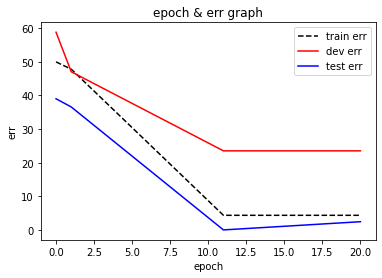

In [17]:
# epoch-err curve
if(to_train):
  plt.plot(x_epoch,y_train_err,color='black',label='train err',linestyle='--')
  plt.plot(x_epoch,y_dev_err,color='red', label='dev err')
  plt.plot(x_epoch, y_test_err,color='blue',label='test err')

  plt.xlabel('epoch')
  plt.ylabel('err')
  plt.title('epoch & err graph')
  plt.legend(loc="upper right")
  plt.show()

# 6. Evaluation for dev & test data

Normalized confusion matrix


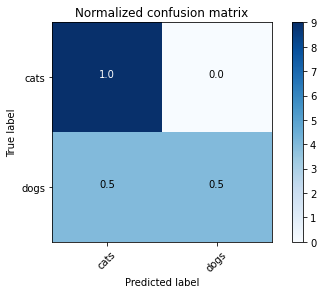

Confusion matrix, without normalization


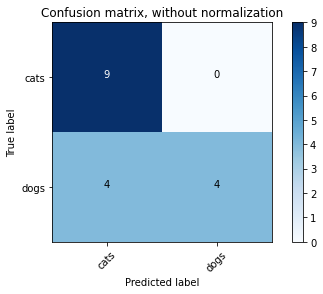

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.76 |	 0.69 |	 1.00 |	 0.82
 dogs: 0.76 |	 1.00 |	 0.50 |	 0.67
*accuracy: 0.76, precision: 0.85, recall: 0.75, *f1 score: 0.74
[AP]
cats: 0.91
dogs: 0.89

[mAP] 0.898
[miAP] 0.882


(array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]),
 array([0.5549385 , 0.93730652, 0.79448527, 0.99206775, 0.99615914,
        0.8397842 , 0.99422228, 0.77349615, 0.712852  , 0.78275025,
        0.99792778, 0.71358711, 0.70793754, 0.99671453, 0.90345246,
        0.81144243, 0.98625618]))

In [18]:
model.eval()  #evaluation(test) mode 로 바꾸기 -> dropout,batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch,model,dev_data.classes,batch_size)

Normalized confusion matrix


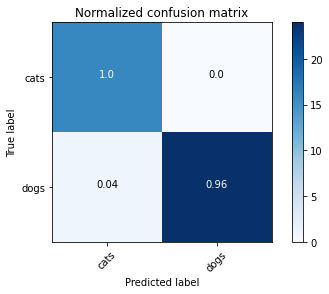

Confusion matrix, without normalization


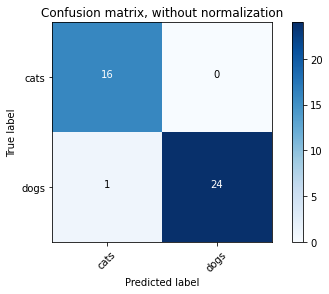

	 acc  |	 pre  |	 rec  |	 f1
 cats: 0.98 |	 0.94 |	 1.00 |	 0.97
 dogs: 0.98 |	 1.00 |	 0.96 |	 0.98
*accuracy: 0.98, precision: 0.97, recall: 0.98, *f1 score: 0.97
[AP]
cats: 1.00
dogs: 1.00

[mAP] 1.000
[miAP] 0.988


In [19]:
model.eval()
_,_,_=utils.EvaluateClassifier(test_batch,model,test_data.classes,batch_size)

Category: cats
 True predicted images/total cats category: 9 / 9
Predicted probability:
[0.99206775 0.00793226]


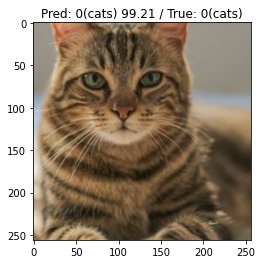

Predicted probability:
[0.90345246 0.09654755]


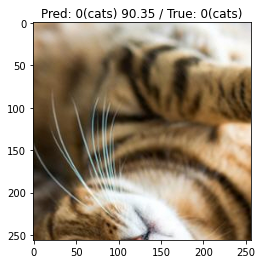

 False predicted images/total cats category: 0 / 9
Category: dogs
 True predicted images/total dogs category: 4 / 8
Predicted probability:
[0.00207222 0.9979278 ]


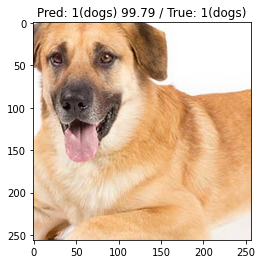

Predicted probability:
[0.21724975 0.78275025]


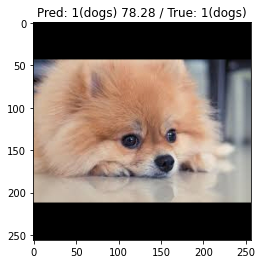

 False predicted images/total dogs category: 4 / 8
Predicted probability:
[0.81144243 0.18855755]


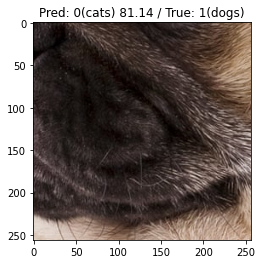

Predicted probability:
[0.77349615 0.22650383]


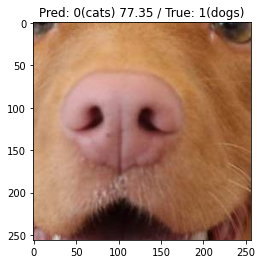

In [21]:
utils.VisTFPred(dev_batch,model,test_data.classes,batch_size,i_n=2)